In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage


In [3]:
ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

In [4]:
path = untar_data(URLs.IMAGENETTE_160,dest=DATA_PATH)
path

Path('../data/imagenette2-160')

In [5]:
(path/'train').ls()

(#10) [Path('../data/imagenette2-160/train/n03394916'),Path('../data/imagenette2-160/train/n03417042'),Path('../data/imagenette2-160/train/n03445777'),Path('../data/imagenette2-160/train/n02102040'),Path('../data/imagenette2-160/train/n03425413'),Path('../data/imagenette2-160/train/n03888257'),Path('../data/imagenette2-160/train/n03028079'),Path('../data/imagenette2-160/train/n03000684'),Path('../data/imagenette2-160/train/n01440764'),Path('../data/imagenette2-160/train/n02979186')]

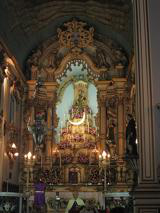

In [81]:
fname = (path/"train/n03028079").ls()[99]
PILImage.create(fname)

In [95]:
??aug_transforms

In [79]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [61]:
import urllib.request, json 
with urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json') as url:
    classes = json.loads(url.read().decode())
f_to_idx = {val[0]:idx for idx,val in classes.items()}
my_classes = [f_to_idx[f.name] for f in (path/"train").ls()]


In [122]:
img = PILImage.create(fname).resize((size,size))
np.array(img).shape, img_to_tensor(img).shape

((160, 160, 3), torch.Size([3, 160, 160]))

In [123]:
def np_to_tensor(array):
    return torch.Tensor(array).permute(2,0,1).float()
def img_to_tensor(img):
    return transforms.ToTensor()(img)
def tensor_to_img(img):
    return (img.permute(1,2,0).numpy()*255.).astype('uint8')

def imresize(arr, sz):
    height, width = sz
    return np.array(arr_to_img(arr).resize((width, height), resample=pilImage.BILINEAR))

def arr_to_img(img, cmap=None):
    def normalize(x): 
        return (x-x.min())/(x.max()-x.min())
    if cmap is not None:
        cm = plt.get_cmap(cmap)
        img = cm(img)[:,:,:3]
    return PILImage.create((normalize(img)*255).astype('uint8'))

# Show linear layer activation function
def show_1D_act(act):
    '''Show activation visualizations of the l-th linear layer with figsize s*s'''
    act_length = act.shape[-1]
    act = act.numpy() if type(act)!=np.ndarray else act
    act = np.array([[act],]*20).reshape(20,act.shape[-1]) # copy linear activation 20x for better visualization
    act = arr_to_img(imresize(act, (20,400)))
    #act = arr_to_img(act).resize((20,5),resample=pilImage.BILINEAR)
    fig, ax = plt.subplots(figsize=(10,1))
    ax.imshow(act, cmap='inferno')
    ax.set_axis_off()

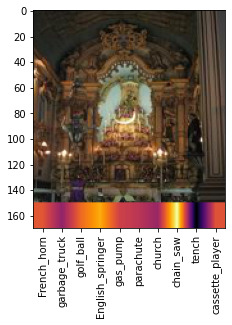

In [132]:
class MyImg():
    def __init__(self,img,model=None,get_model_act=False,restrict_classes=None):
        self.img_orig = img.copy()
        self.img = img.copy()
        self.x_orig = img_to_tensor(img).unsqueeze(0)
        self.x = img_to_tensor(img).unsqueeze(0)
        self.model = model
        self.get_model_act = get_model_act
        self.images = []
        self.activations = []
        self.restrict_classes = restrict_classes
        self.class_idx = [int(i) for i in restrict_classes.keys()]
        
    def reset(self):
        self.img = self.img_orig.copy()
        self.x = self.x_orig # does this work without some kind of copy ? in tfms() it seems to work
        self.images = []
        self.activations = []
        
    def tfm_brightness(self, brightness, show=False):
        x =  TF.adjust_brightness(self.x, brightness)
        if show:
            plt.imshow(tensor_to_img(x[0]))
        return x
    
    def tfm_centercrop(self, crop_size, show=False):
        x =  transforms.CenterCrop(crop_size)(self.x)
        if show:
            plt.imshow(tensor_to_img(x[0]))
        return x  
    
    def tfms(self, brightness=None, crop_size=None, show=True):
        self.x = self.x_orig#.copy()
        if brightness is not None:
            self.x = self.tfm_brightness(brightness)
        if crop_size is not None:
            self.x = self.tfm_centercrop(crop_size)
        
        if self.get_model_act:
            out = self.model(normalize(self.x)).detach().numpy()
            if self.restrict_classes is not None:
                out = out[:,self.class_idx]
            self.activations.append(out)
            img = self.combine_activation_with_img(out)
        else:
            img = tensor_to_img(self.x[0])
        self.images.append(img)
        if show:
            plt.imshow(img)
            my_xticks = self.restrict_classes.values()
            nr_classes = len(self.restrict_classes)
            w,h,d = img.shape
            img_size = min(w,h)
            step_size = img_size//nr_classes
            plt.xticks(np.arange(step_size//2,img_size,step_size), my_xticks,rotation=90)
            
         
    def combine_activation_with_img(self, out):
        # to make flatten activation better visible, the images will be streched by a factor of 20 
        # and the width is adapted to the original image width
        shape = (20,self.x.shape[2])
        transform_act = lambda x: arr_to_img(imresize(x,shape), 'inferno') 
        #transform_act = lambda x: arr_to_img(x).resize(shape),resample=pilImage.BILINEAR)

        # combine transformed images and their layer activations
        img_comb = np.vstack([tensor_to_img(self.x[0]), transform_act(out) ])
        return img_comb
    
    def create_gif(self,path): 
        # to make flatten activation better visible, the images will be streched by a factor of 20 and the width is adapted to the original image width
        w,h,d = self.images[0].shape
        transform_act = lambda x: arr_to_img(imresize(x,(20,w)), 'inferno') 

        # combine sequence of transformed images and their layer activations
        imgs_combs = [ np.vstack([arr_to_img(img).resize((w,h)), transform_act(act) ]) for img, act in zip(self.images,self.activations)  ]

        # transform to images, add backward loop and store as gif
        first_img, *imgs = [ pilImage.fromarray( img ) for img in imgs_combs]
        imgs += [img for img in imgs[::-1]]
        first_img.save(fp=path, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)


size = 160
img = PILImage.create(fname).resize((size,size))
myimg = MyImg(img,
              model,
              get_model_act=True,
              restrict_classes={i:classes[i][1] for i in my_classes})
myimg.tfms(crop_size=150)

In [129]:
(myimg.x).mean()

tensor(0.2490)

In [109]:
img = PILImage.create(fname)
torch.Tensor(np.array(img)).permute(2,0,1).float()

tensor([[[27., 30., 31.,  ..., 62., 62., 63.],
         [27., 29., 31.,  ..., 62., 62., 63.],
         [26., 28., 31.,  ..., 62., 62., 63.],
         ...,
         [45., 51., 51.,  ..., 51., 18.,  8.],
         [23., 26., 16.,  ..., 49., 17.,  7.],
         [23., 27., 12.,  ..., 46., 15.,  6.]],

        [[32., 35., 33.,  ..., 58., 58., 57.],
         [32., 34., 33.,  ..., 58., 58., 57.],
         [31., 33., 33.,  ..., 58., 58., 57.],
         ...,
         [52., 58., 58.,  ..., 50., 17.,  7.],
         [28., 31., 21.,  ..., 48., 16.,  6.],
         [25., 29., 14.,  ..., 45., 14.,  5.]],

        [[28., 31., 30.,  ..., 57., 57., 57.],
         [28., 30., 30.,  ..., 57., 57., 57.],
         [27., 29., 30.,  ..., 57., 57., 57.],
         ...,
         [45., 51., 51.,  ..., 46., 13.,  3.],
         [22., 25., 15.,  ..., 44., 12.,  2.],
         [20., 24.,  9.,  ..., 41., 10.,  1.]]])

In [106]:
transforms.ToTensor()(PILImage.create(fname))

tensor([[[0.1059, 0.1176, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         [0.1059, 0.1137, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         [0.1020, 0.1098, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         ...,
         [0.1765, 0.2000, 0.2000,  ..., 0.2000, 0.0706, 0.0314],
         [0.0902, 0.1020, 0.0627,  ..., 0.1922, 0.0667, 0.0275],
         [0.0902, 0.1059, 0.0471,  ..., 0.1804, 0.0588, 0.0235]],

        [[0.1255, 0.1373, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         [0.1255, 0.1333, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         [0.1216, 0.1294, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         ...,
         [0.2039, 0.2275, 0.2275,  ..., 0.1961, 0.0667, 0.0275],
         [0.1098, 0.1216, 0.0824,  ..., 0.1882, 0.0627, 0.0235],
         [0.0980, 0.1137, 0.0549,  ..., 0.1765, 0.0549, 0.0196]],

        [[0.1098, 0.1216, 0.1176,  ..., 0.2235, 0.2235, 0.2235],
         [0.1098, 0.1176, 0.1176,  ..., 0.2235, 0.2235, 0.2235],
         [0.1059, 0.1137, 0.1176,  ..., 0.2235, 0.2235, 0.

In [105]:
transforms.ToTensor()(pilImage.open(fname))

tensor([[[0.1059, 0.1176, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         [0.1059, 0.1137, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         [0.1020, 0.1098, 0.1216,  ..., 0.2431, 0.2431, 0.2471],
         ...,
         [0.1765, 0.2000, 0.2000,  ..., 0.2000, 0.0706, 0.0314],
         [0.0902, 0.1020, 0.0627,  ..., 0.1922, 0.0667, 0.0275],
         [0.0902, 0.1059, 0.0471,  ..., 0.1804, 0.0588, 0.0235]],

        [[0.1255, 0.1373, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         [0.1255, 0.1333, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         [0.1216, 0.1294, 0.1294,  ..., 0.2275, 0.2275, 0.2235],
         ...,
         [0.2039, 0.2275, 0.2275,  ..., 0.1961, 0.0667, 0.0275],
         [0.1098, 0.1216, 0.0824,  ..., 0.1882, 0.0627, 0.0235],
         [0.0980, 0.1137, 0.0549,  ..., 0.1765, 0.0549, 0.0196]],

        [[0.1098, 0.1216, 0.1176,  ..., 0.2235, 0.2235, 0.2235],
         [0.1098, 0.1176, 0.1176,  ..., 0.2235, 0.2235, 0.2235],
         [0.1059, 0.1137, 0.1176,  ..., 0.2235, 0.2235, 0.

In [100]:
myimg.x.shape

torch.Size([1, 3, 150, 150])

In [101]:
Normalize.from_stats(*imagenet_stats)#(myimg.x)

Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
decodes: (TensorImage,object) -> decodes

In [94]:
myimg.x

tensor([[[[ 25.,  28.,  34.,  ...,  59.,  59.,  59.],
          [ 29.,  32.,  33.,  ...,  60.,  60.,  60.],
          [ 29.,  31.,  32.,  ...,  60.,  60.,  60.],
          ...,
          [ 29.,  59.,  62.,  ...,  46.,  46.,  46.],
          [ 61.,  81.,  53.,  ...,  26.,  25.,  24.],
          [101., 105.,  88.,  ...,  34.,  33.,  32.]],

         [[ 27.,  29.,  35.,  ...,  59.,  59.,  59.],
          [ 31.,  33.,  34.,  ...,  60.,  60.,  60.],
          [ 31.,  32.,  33.,  ...,  60.,  60.,  60.],
          ...,
          [ 32.,  62.,  64.,  ...,  43.,  43.,  43.],
          [ 66.,  85.,  57.,  ...,  23.,  22.,  21.],
          [108., 111.,  94.,  ...,  31.,  30.,  29.]],

         [[ 22.,  24.,  30.,  ...,  59.,  59.,  59.],
          [ 26.,  28.,  29.,  ...,  60.,  60.,  60.],
          [ 26.,  27.,  28.,  ...,  60.,  60.,  60.],
          ...,
          [ 27.,  55.,  58.,  ...,  38.,  38.,  38.],
          [ 60.,  78.,  50.,  ...,  18.,  17.,  16.],
          [101., 104.,  87.,  ...

In [93]:
normalize(myimg.x)#.mean()

tensor([[[[107.0524, 120.1528, 146.3537,  ..., 255.5240, 255.5240, 255.5240],
          [124.5196, 137.6201, 141.9869,  ..., 259.8908, 259.8908, 259.8908],
          [124.5196, 133.2533, 137.6201,  ..., 259.8908, 259.8908, 259.8908],
          ...,
          [124.5196, 255.5240, 268.6245,  ..., 198.7554, 198.7554, 198.7554],
          [264.2576, 351.5939, 229.3231,  ..., 111.4192, 107.0524, 102.6856],
          [438.9301, 456.3974, 382.1616,  ..., 146.3537, 141.9869, 137.6201]],

         [[118.5000, 127.4286, 154.2143,  ..., 261.3571, 261.3571, 261.3571],
          [136.3571, 145.2857, 149.7500,  ..., 265.8214, 265.8214, 265.8214],
          [136.3571, 140.8214, 145.2857,  ..., 265.8214, 265.8214, 265.8214],
          ...,
          [140.8214, 274.7500, 283.6786,  ..., 189.9286, 189.9286, 189.9286],
          [292.6071, 377.4286, 252.4286,  ..., 100.6429,  96.1786,  91.7143],
          [480.1071, 493.5000, 417.6071,  ..., 136.3571, 131.8929, 127.4286]],

         [[ 95.9733, 104.8622,

In [64]:
# check this !!
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [50]:
myimg.class_idx

[566, 569, 574, 217, 571, 701, 497, 491, 0, 482]

In [49]:
{i:classes[i][1] for i in my_classes}.keys()

dict_keys(['566', '569', '574', '217', '571', '701', '497', '491', '0', '482'])

In [38]:
map({i:classes[i][1] for i in my_classes}.keys(),int)

TypeError: 'type' object is not iterable

In [31]:
myimg.images[0].shape

(170, 150, 3)

In [134]:
import ipywidgets as widgets
slider_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,stepsize=0.2)
slider_crop_size = widgets.IntSlider(value=100,min=33,max=160,stepsize=5)

In [135]:
def create_gif_on_click(change):
    myimg.create_gif(IMGS_PATH/'test2.gif')
    #out_pl.clear_output()
    #with out_pl: display(img.to_thumb(128,128))
btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

In [136]:
myimg.reset()
out_tfms = widgets.interactive_output(myimg.tfms, {"brightness":slider_brightness,"crop_size":slider_crop_size})
#out_tfms.clear_output()
widgets.HBox([widgets.VBox([slider_brightness,slider_crop_size,btn_create_gif]), out_tfms])

[SegmentLocal](../imgs/test2.gif "segment")


[SegmentLocal](../imgs/test.gif "segment")
[SegmentLocal](../imgs/results/test.gif "segment")


In [38]:
# to save the images separate 
#os.makedirs('../imgs/img_list/',exist_ok=True)
#os.makedirs('../imgs/results/',exist_ok=True)
#
#for i,pic in enumerate(imgs):
#    pic.save(fp=f'../imgs/img_list/img_{str(i).zfill(2)}.png', format='PNG')

# to use ffmpeg I need to deactivate conda and call this in the terminal
# but it doesn't seem for me that the results are better, so I leave it for now
#ffmpeg -f image2 -i imgs/img_list/img_%02d.png -vf scale=2480:-1:sws_dither=ed,palettegen imgs/results/palette.png -y
#ffmpeg -f image2 -framerate 10. -i imgs/img_list/img_%02d.png imgs/results/img.flv -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" imgs/results/test.gif -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" -loop -1 imgs/results/test_no_loop.gif -y
